# Understanding and Implementing the mAP Metric for Object Detection 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib.util import find_spec
if find_spec("model") is None:
    import sys
    sys.path.append('..')

In [3]:
import torch
from fastai.vision.all import *
from copy import deepcopy
import numpy as np

In [4]:
from data_loader.data_loaders import load_sample_coco_dls
from model.model import retina_resnet50
from model.loss import RetinaLoss
from utils.box_utils import pairwise_iou, remove_zero_area_bboxes_i

# Understanding Mean Average Precision (mAP) 

## Understanding Precision and Recall

First we need to understand what we mean by `Precision` and `Recall`.

$$precision = \frac{TP}{TP + FP}\text{, } recall = \frac{TP}{TP + FN}$$

### What is Precision?

Precision measures the amount of "Truthiness" when the model predicts that a label is true. In other words, it represents the `ratio of True Positives w.r.t all predictions that are predicted as true (True Positives + False Positives).`

### What is Recall?

Recall on the other hand measures the ability to detect Truth. In other words, it represents the `ratio of True Positives w.r.t all instances of there being Truth (True Positives + False Negatives.`

## Understanding Average Precision

Now that we know what Precision and Recall mean we can define `Average Precision` easily.

### What is Average Precision?

Average Precision is the simply taking the average of all maximum possible precisions for any given amount of Recall within out interest. For example, if we have two different Precisions with one being 90% and the other being 96% given a Recall value of 10% we select the maximal Precision which in this case is 96%. Now, lets say that we are interested in finding the Average Precision for Recall values of 10% increaments. Then we would basically have to sum up all maximal Precisions for each 10% increament and divide the amount by 10 to get the Average Precision. In other words, Average Precision is `the sum of maximal Precisions over the n Recall values of interest divided by n.`

$$Average Precision = \frac{\sum_{i = n}Precision_{max}(Recall_i)}{n}$$

## Understanding Mean Average Precision 

Since we now understand understand Avergage Precision we are ready to delve into `Mean Average Precision.`

## What is Mean Average Precision (mAP)?

The Mean Average Precision is used most popularily in Object Detection tasks. So, we will take Object Detection as the running example.

Each prediction in a multiclass Object Detection problem can have multiple classes associated with it. So to have a metric to measure how well the model is doing we can simply take the literal "mean" of all Average Precisions over all classes. However, this is only a metric so far that measures how good the classification part of the problem is doing. What about localization? Well we can simply use the `IOU (Intersection Over Union)` to threshold whether a prediction that has been labeled correctly is considered truly a True Positive. In other words, we use the IOU as a filtering method for how good the True Positive lables are. By doing so we are effectively able to also measure the "goodness" of the predicted bounding boxes. For example, if our threshold is `IOU = 50%` then we can calculate $mAP_{50}$ by taking the mean of the Average Precision over all classes at the 50% mark. 

However, there is one more level that to this in the case of the COCO dataset where we take the mean of the mAPs (something like a mean Mean Average Precision) over multiple different IOU thresholds.

# Implementing mAP

In [5]:
def calc_iou_single(pred_box, gt_box):
    """Calculate IoU of single predicted and ground truth box
    Args:
        pred_box (list of floats): location of predicted object as
            [xmin, ymin, xmax, ymax]
        gt_box (list of floats): location of ground truth object as
            [xmin, ymin, xmax, ymax]
            
    Returns:
        float: value of the IoU for the two boxes.
        
    Raises:
        AssertionError: if the box is obviously malformed
    """
    x1_t, y1_t, x2_t, y2_t = gt_box
    x1_p, y1_p, x2_p, y2_p = pred_box
    
    if (x1_p > x2_p) or (y1_p > y2_p):
        raise AssertionError(
            "Prediction box is malformed? pred box: {}".format(pred_box))
    
    if (x1_t > x2_t) or (y1_t > y2_t):
        raise AssertionError(
            "Ground Truth box is malformed? true box: {}".format(gt_box))
        
    if (x2_t < x1_p or x2_p < x1_t or y2_t < y1_p or y2_p < y1_t):
        return 0.0
    
    far_x  = np.min([x2_t, x2_p])
    near_x = np.max([x1_t, x1_p])
    far_y = np.min([y2_t, y2_p])
    near_y = np.max([y1_t, y1_p])
    
    inter_area = (far_x - near_x + 1) * (far_y - near_y + 1)
    true_box_area = (x2_t - x1_t + 1) * (y2_t - y1_t + 1)
    pred_box_area = (x2_p - x1_p + 1) * (y2_p - y1_p + 1)
    iou = inter_area / (true_box_area + pred_box_area - inter_area)
    return iou

In [6]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thresh):
    """
    Get results for a single batch.
    
    Calculate the number of `true_pos`, `false_pos`, `false_neg`.
    
    Args:
    gt_boxes (list of list of floats): list of locations of ground truth
        objects as [xmin, ymin, xmax, ymax]
    pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
        and 'scores'
    iou_thresh (float): value of IoU to consider as threshold for a
        true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    all_pred_indices = range(len(pred_boxes))
    all_gt_indices = range(len(gt_boxes))
    
    if len(all_pred_indices) == 0:
        return {'true_pos': 0, 'false_pos': 0, 'false_neg': len(gt_boxes)}
    
    if len(all_gt_indices) == 0:
        return {'true_pos': 0, 'false_pos': len(pred_boxes), 'false_neg': 0}
    
    gt_idx_thresh, pred_idx_thresh, ious = [], [], []
    
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou = calc_iou_single(pred_box, gt_box)
            if iou > iou_thresh:
                gt_idx_thresh.append(igb)
                pred_idx_thresh.append(ipb)
                ious.append(iou)
    
    args_desc = np.argsort(ious)[::-1]
    
    if len(args_desc) == 0:
        # No Matches.
        tp = 0
        fp = len(pred_boxes)
        fn = len(gt_boxes)
        
    else:
        gt_match_idx = []
        pred_match_idx = []
        
        for idx in args_desc:
            gt_idx = gt_idx_thresh[idx]
            pred_idx = pred_idx_thresh[idx]
            
            # If the boxes are unmatched, add them to matches.
            if (gt_idx not in gt_match_idx) and (pred_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pred_idx)
        tp = len(gt_match_idx)
        fp = len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
        
    return {"true_pos": tp, "false_pos": fp, "false_neg": fn}

In [7]:
def calc_precision_recall(img_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    tp, fp, fn = 0, 0, 0
    for _, res in img_results.items():
        tp += res["true_pos"]
        fp += res["false_pos"]
        fn += res["false_neg"]
    try:
        precision = tp / (tp + fp)
    except ZeroDivisionError:
        precision = 0.0
    
    try:
        recall = tp / (tp + fn)
    except ZeroDivisionError:
        recall = 0.0
        
    return precision, recall

In [8]:
def get_model_scores_map(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_scores_map = {}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_scores_map.keys():
                model_scores_map[score] = [img_id]
            else:
                model_scores_map[score].append(img_id)
    return model_scores_map

In [9]:
def get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=0.5):
    """Calculates average precision at given IoU threshold.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (list of list of floats): list of locations of predicted
            objects as [xmin, ymin, xmax, ymax]
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: avg precision as well as summary info about the PR curve
        Keys:
            'avg_prec' (float): average precision for this IoU threshold
            'precisions' (list of floats): precision value for the given
                model_threshold
            'recall' (list of floats): recall value for given
                model_threshold
            'models_thrs' (list of floats): model threshold value that
                precision and recall were computed for.
    """
    model_scores_map = get_model_scores_map(pred_boxes)
    sorted_model_scores = sorted(model_scores_map.keys())
    
    # Sort the predicted boxes in descending order (lowest scoring boxes first).
    for img_id in pred_boxes.keys():
        arg_sort = np.argsort(pred_boxes[img_id]['scores'])
        pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id]['scores'])[arg_sort].tolist()
        pred_boxes[img_id]['boxes'] = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()
    
    pred_boxes_pruned = deepcopy(pred_boxes)
    
    precisions, recalls, model_threshs, img_results = [], [], [], {}
    
    # Loop over model score thresholds and calc precision, recall.
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores_map[model_score_thr]
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break 
                    
            # Remove boxes, scores for lower than thresh scores.
            pred_boxes_pruned[img_id]['scores'] = pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes'] = pred_boxes_pruned[img_id]['boxes'][start_idx:]
            
            # Recalculate img results for this img.
            img_results[img_id] = get_single_image_results(gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)
        prec, rec = calc_precision_recall(img_results) 
        precisions.append(prec)
        recalls.append(rec)
        model_threshs.append(model_score_thr)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_lev in np.linespace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_lev).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)
    
    return {
        "avg_prec": avg_prec,
        "precisions": precisions,
        "recalls": recalls,
        "model_thrs": model_thrs
    }

In [10]:
def plot_pr_curve(
    precisions, recalls, category='Person', label=None, color=None, ax=None):
    """Simple plotting helper function"""

    if ax is None:
        plt.figure(figsize=(10,8))
        ax = plt.gca()

    if color is None:
        color = COLORS[0]
    ax.scatter(recalls, precisions, label=label, s=20, color=color)
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision-Recall curve for {}'.format(category))
    ax.set_xlim([0.0,1.3])
    ax.set_ylim([0.0,1.2])
    return ax

# My Own Implementation of mAP

## Recall/Precision

In [11]:
def recall(true_pos: int, false_neg: int):
    return true_pos / (true_pos + false_neg)

def precision(true_pos: int, false_pos):
    return true_pos / (true_pos + false_pos)

## Average Precision

In [12]:
def avg_precision(pred_bboxes: torch.Tensor, pred_lbls: torch.Tensor, gt_bboxes: torch.Tensor, gt_lbls: torch.Tensor, iou_thresh: float):
    """
    Calculate Average Precision given an `iou_thresh` for a single batch.
    """
    bs = len(pred_bboxes)
    for i in range(bs):
        t_bbboxes_i, t_lbls_i = remove_zero_area_bboxes_i(gt_bboxes[i], gt_lbls[i])
        iou = pairwise_iou(pred_bboxes[i], t_bbboxes_i)

# FastAI Implementation of mAP 
> Found in `pascal.ipynb`

In [5]:
def mAP(model, dl, n_classes):
    L = compute_class_AP(model, dl, n_classes)
    num_cats = len(L)
    total_ap = 0
    for ap in L:
        total_ap += ap
    return total_ap / num_cats

In [6]:
def compute_class_AP(model, dl, n_classes, iou_thresh=0.5, detect_thresh=0.35, num_keep=100):
    tps, clas, p_scores = [], [], []
    classes, n_gts = LongTensor(range(n_classes)), torch.zeros(n_classes).long()
    with torch.no_grad():
        for imgs, boxes, lbls in progress_bar(dl):
            bs = boxes.size(0)
            output = model(imgs)
            for i in range(bs):
                bbox_pred, preds, scores = get_predictions(output, i, detect_thresh)
                tgt_bbox, tgt_clas = unpad(boxes[i], lbls[i])
                if len(bbox_pred) != 0 and len(tgt_bbox) != 0:
                    ious = pairwise_iou(bbox_pred, tgt_bbox)
                    max_iou, matches = ious.max(1)
                    detected = []
                    for i in range(preds):
                        if max_iou[i] >= iou_thresh and matches[i] not in detected and tgt_clas[matches[i]] == preds[i]:
                            detected.append(matches[i])
                            tps.append(1)
                        else: tps.append(0)
                    clas.append(preds.cpu())
                    p_scores.append(scores.cpu())
                n_gts += (tgt_clas.cpu()[:, None] == classes[None, :]).sum(0)
    tps, p_scores, clas = torch.tensor(tps), torch.cat(p_scores, 0), torch.cat(clas, 0)
    fps = 1 - tps
    idx = p_scores.argsort(descending=True)
    tps, fps, clas = tps[idx], fps[idx], clas[idx]
    aps = []
    eps = 1e-8
    for cls in range(n_classes):
        tps_cls, fps_cls = tps[clas==cls].float().cumsum(0), fps[clas==cls].float().cumsum(0)
        if tps_cls.numel() != 0 and tps_cls[-1] != 0:
            precision = tps_cls / (tps_cls + fps_cls + eps)
            recall = tps_cls / (n_gts[cls] + eps)
            aps.append(compute_ap(precision, recall))
        else:
            aps.append(0.)
    return aps 

In [7]:
def compute_ap(precision, recall):
    """Compute the average precision for `precision` and `recall` curve."""
    recall = np.concatenate(([0.], list(recall), [1.]))
    precision = np.concatenate(([0.], list(precision), [1.]))
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])
    idx = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[idx + 1] - recall[idx]) * precision[idx + 1])
    return ap

In [8]:
def get_predictions(output, idx, detect_thresh=0.05):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    if len(scores) == 0: return [],[],[]
    to_keep = nms(bbox_pred, scores)
    return bbox_pred[to_keep], preds[to_keep], scores[to_keep]

In [9]:
def process_output(output, i, detect_thresh=0.25):
    ## clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    clas_pred = torch.cat(output["pred_logits"], 1)[i]
    bbox_pred = torch.cat(output["pred_bboxes"], 1)[i]
    anchors = output["anchors"]
    anchors = concat_anchors(anchors)
    ## anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    if clas_pred.numel() == 0: return [],[],[]
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds

In [10]:
def concat_anchors(anchors, flatten=True):
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

In [11]:
def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    if flatten:
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]])) #Can't remember where those scales come from, but they help regularize
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2]
        sizes = anchors[...,2:] * torch.exp(acts[...,:2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [12]:
def bbox_to_activ(bboxes, anchors, flatten=True):
    "Return the target of the model on `anchors` for the `bboxes`."
    if flatten:
        t_centers = (bboxes[...,:2] - anchors[...,:2]) / anchors[...,2:] 
        t_sizes = torch.log(bboxes[...,2:] / anchors[...,2:] + 1e-8) 
        return torch.cat([t_centers, t_sizes], -1).div_(bboxes.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [13]:
def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

In [14]:
def tlbr2cthw(boxes):
    "Convert top/left bottom/right format `boxes` to center/size corners."
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)

In [15]:
def nms(boxes, scores, thresh=0.3):
    idx_sort = scores.argsort(descending=True)
    boxes, scores = boxes[idx_sort], scores[idx_sort]
    to_keep, indexes = [], torch.LongTensor(range_of(scores))
    while len(scores) > 0:
        to_keep.append(idx_sort[indexes[0]])
        iou_vals = pairwise_iou(boxes, boxes[:1]).squeeze()
        mask_keep = iou_vals < thresh
        if len(mask_keep.nonzero()) == 0: break
        boxes, scores, indexes = boxes[mask_keep], scores[mask_keep], indexes[mask_keep]
    return LongTensor(to_keep)

## Test out mAP

In [16]:
dls = load_sample_coco_dls(bs=16)

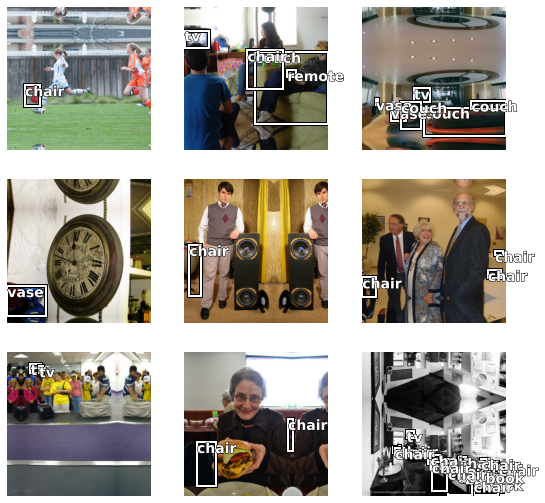

In [17]:
dls.show_batch()

In [18]:
num_classes = 6

In [19]:
dls.c = num_classes

In [20]:
model = retina_resnet50(num_classes=num_classes)
crit = RetinaLoss(num_classes=num_classes)

In [21]:
def _retinanet_split(m): return L(m.base, nn.Sequential(m.backbone, m.head)).map(params)

In [22]:
learn = Learner(dls, model, loss_func=crit, splitter=_retinanet_split)

In [23]:
learn.load??

Signature: learn.load(file, with_opt=None, device=None, strict=True)
Docstring: Load model and optimizer state (if `with_opt`) from `self.path/self.model_dir/file` using `device`
Source:   
    @delegates(load_model)
    def load(self, file, with_opt=None, device=None, **kwargs):
        if device is None and hasattr(self.dls, 'device'): device = self.dls.device
        if self.opt is None: self.create_opt()
        file = join_path_file(file, self.path/self.model_dir, ext='.pth')
        load_model(file, self.model, self.opt, device=device, **kwargs)
        return self
File:      ~/anaconda3/envs/fastml/lib/python3.8/site-packages/fastai/learner.py
Type:      method


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
learn.load("coco_retina50", device=device)

In [26]:
learn.model = learn.model.to(device)

In [ ]:
L = compute_class_AP(learn.model, dls.valid, dls.c-1)